In [1]:
import os
import json
from pprint import pprint

import pandas as pd

import networkx as nx

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

import umap

In [2]:
import numpy as np

In [3]:
import plotly.express as px

In [4]:
from plotly.offline import plot

In [5]:
def get_simplified_data(item):

    album_dict = {}
    track_dict = {}

    #album
    album_dict['album_type'] = item['track']['album']['album_type']
    album_dict['artists'] = '-'.join(sorted([artist['name'] for artist in item['track']['album']['artists']])) #list
    album_dict['name'] = item['track']['album']['name']
    album_dict['id'] = item['track']['album']['id']
    album_dict['total_tracks'] = item['track']['album']['total_tracks']
    album_dict['release_date'] = item['track']['album']['release_date']

    #track

    track_dict['artists'] = '-'.join(sorted([artist['name'] for artist in item['track']['artists']]))
    track_dict['duration_ms'] = item['track']['duration_ms']
    track_dict['name'] = item['track']['name']
    track_dict['track_number'] = item['track']['track_number']
    track_dict['id'] = item['track']['id']
    track_dict['album_id'] = item['track']['album']['id']
    track_dict['played_at'] = item['played_at']

    return track_dict, album_dict

In [6]:
data_dir = os.fsencode(os.path.join(os.path.curdir, 'data'))

In [7]:
tracks_df_columns = ['artists',
                     'duration_ms',
                     'name',
                     'track_number',
                     'id',
                     'album_id',
                     'played_at']

albums_df_columns = ['album_type', 'artists', 'name', 'id', 'total_tracks', 'release_date']

In [8]:
tracks_df = pd.DataFrame(columns=tracks_df_columns)
albums_df = pd.DataFrame(columns=albums_df_columns)

for file in os.listdir(data_dir):
    filename = os.fsdecode(file)
    if filename.endswith('.json'):
        if filename.startswith('recently'):
            with open(os.path.join(os.fsdecode(data_dir), filename), 'r') as f:
                data_json = json.load(f)
            for item in data_json['items']:
                track, album = get_simplified_data(item)
                tracks_df = tracks_df.append(pd.Series(track).to_frame().T, ignore_index = True)
                albums_df = albums_df.append(pd.Series(album).to_frame().T, ignore_index = True)
                    
        if filename.startswith('audio'):
            continue

In [9]:
tracks_df.drop_duplicates(inplace=True)

In [10]:
albums_df.drop_duplicates(inplace=True)

In [11]:
tracks_df.shape

(2284, 7)

In [12]:
albums_df.shape

(465, 6)

In [13]:
tracks_df.played_at = pd.to_datetime(tracks_df.played_at, utc=None)
tracks_df = tracks_df.sort_values('played_at')

# bar chart race animation per month

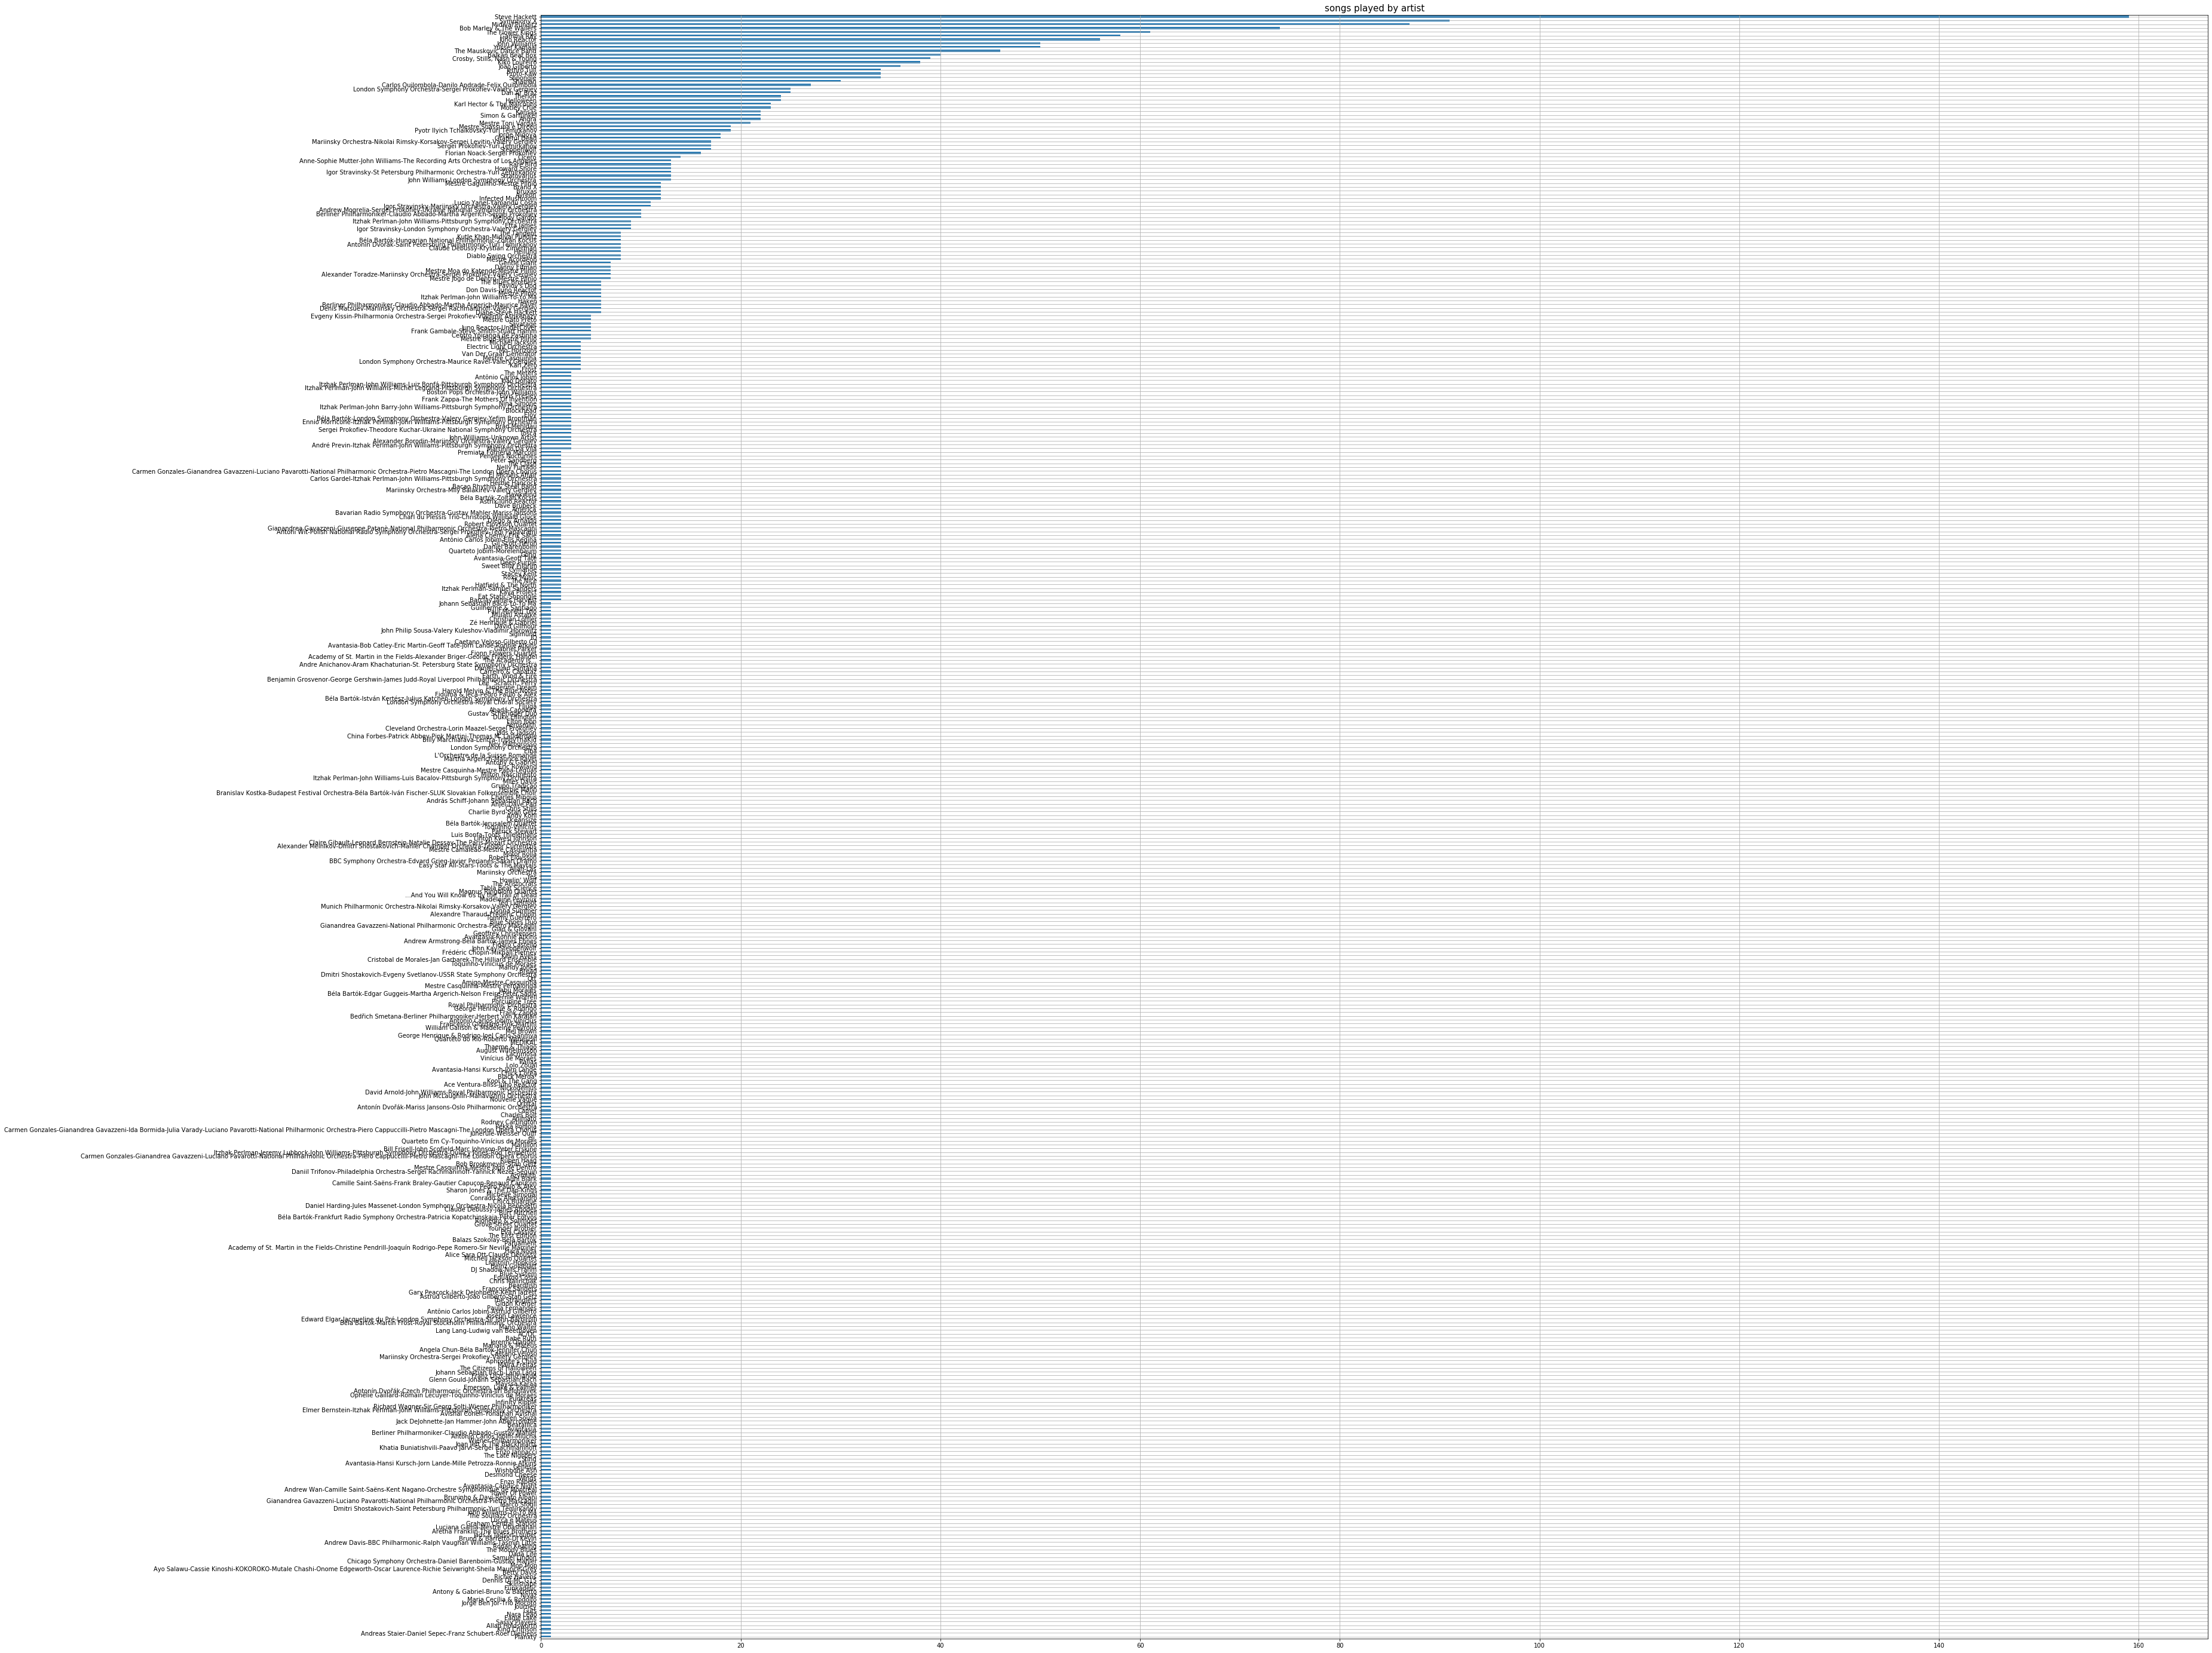

In [14]:
fig, ax = plt.subplots(figsize=(50, 50))
tracks_df.artists.value_counts(ascending=True).plot.barh(ax=ax, 
                                          grid=True)
ax.set_title('songs played by artist', fontsize=15)
plt.savefig('./figures/songs_played_by_artist.png')

In [15]:
count_by_month = tracks_df.groupby([tracks_df.played_at.dt.year, tracks_df.played_at.dt.month, 'artists']).size()
count_by_month = count_by_month.sort_values(ascending=False).sort_index(level=[0, 1])

count_by_month

played_at  played_at  artists                                             
2019       8          Alexander Borodin-Mariinsky Orchestra-Valery Gergiev     1
                      Animato                                                  1
                      Ayreon                                                   1
                      Bacao Rhythm & Steel Band                                1
                      Balkan Beat Box                                          8
                                                                              ..
2020       3          Yussef Kamaal                                            7
                      Zé Henrique & Gabriel                                    1
                      eli.                                                     1
           4          Luciana Gama-Mestre Obashanan                            1
                      Mestre Toni Vargas                                      21
Length: 608, dtype: int64

In [16]:
def draw_barchart(year_month):
    year, month = year_month
    ax.clear()
    dff = count_by_month.loc[year, month].sort_values(ascending=True).tail(10)
    dx = dff.max() / 200
    dff.plot.barh(ax=ax)
    #ax.set_title('songs played by artist at {}-{}'.format(year, month), fontsize=15)
    for i, (name, value) in enumerate(dff.to_frame().reset_index().values):
        ax.text(value, 
                i-.1, 
                name, 
                size=14, 
                weight=600, 
                ha='right', 
                va='bottom',
                c='white')
        ax.text(value+dx, 
                i,     
                f'{value:,.0f}',  
                size=14, 
                ha='left',  
                va='center')
        #ax.text(value, i-.25, group_lk[name],  ha='right')  # Asia: group name
        #ax.text(value, i,     value,           ha='left')   # 38194.2: value
    # Add year right middle portion of canvas
    #ax.text(1, 0.4, '{}-{}'.format(month, year), transform=ax.transAxes, size=46, ha='right')
    # ... polished styles
    ax.text(1, 0.4, '{}-{}'.format(month, year), transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Songs played', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    #ax.text(0, 1.12, 'songs played by artist',
    #        transform=ax.transAxes, size=24, weight=600, ha='left')
    #ax.text(1, 0, 'by @pratapvardhan; credit @jburnmurdoch', transform=ax.transAxes, ha='right',
    #        color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    #plt.savefig('./figures/songs_played_by_artist_{}_{}.png'.format(year, month))

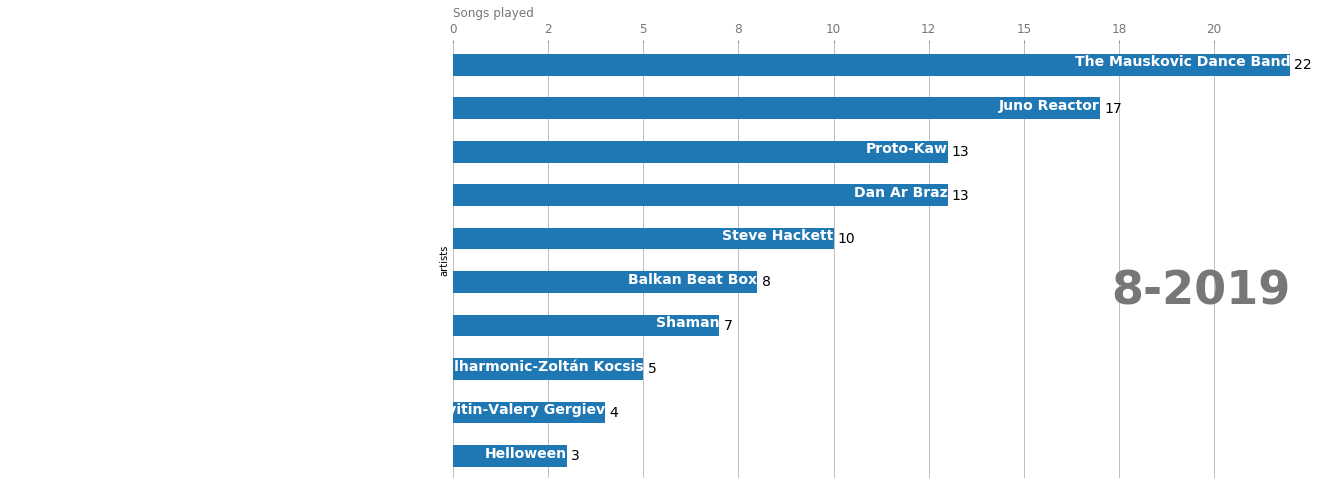

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_xlim([0, count_by_month.max()])

animator = animation.FuncAnimation(fig, 
                                   draw_barchart, 
                                   frames=count_by_month.index.droplevel(2).drop_duplicates().values, 
                                   interval=1000)
HTML(animator.to_html5_video()) 
animator.save('./figures/songs_played_by_artist_monthly.mp4')

In [18]:
count_by_month = tracks_df.groupby([tracks_df.played_at.dt.year, tracks_df.played_at.dt.month, 'artists']).size()
count_by_month = count_by_month.sort_values(ascending=False).sort_index(level=[0, 1])

In [19]:
import pytz

In [20]:
dff = tracks_df[tracks_df.played_at < pd.datetime(2020, 2, 1, tzinfo=pytz.UTC)]
dff.groupby('artists').size().sort_values(ascending=True).tail(10)

/Users/claudioborile/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



artists
Proto-Kaw                    25
Gamma Ray                    29
Yussef Kamaal                33
The Mauskovic Dance Band     37
The Flower Kings             44
Juno Reactor                 50
Symphony X                   68
Bob Marley & The Wailers     74
Midival Punditz              78
Steve Hackett               128
dtype: int64

In [21]:
def draw_barchart(date):
    year = date.date().year
    month = date.date().month
    day = date.date().day
    ax.clear()
    ax.set_xlim([0, tracks_df.groupby('artists').size().max()])
    dff = tracks_df[tracks_df.played_at < pd.datetime(year, month, day, tzinfo=pytz.UTC)]
    dff = dff.groupby('artists').size().sort_values(ascending=True).tail(10)
    dx = dff.max() / 200
    dff.plot.barh(ax=ax)
    #ax.set_title('songs played by artist at {}-{}'.format(year, month), fontsize=15)
    for i, (name, value) in enumerate(dff.to_frame().reset_index().values):
        ax.text(value, 
                i-.1, 
                name, 
                size=14, 
                weight=600, 
                ha='right', 
                va='bottom',
                c='white')
        ax.text(value+dx, 
                i,     
                f'{value:,.0f}',  
                size=14, 
                ha='left',  
                va='center')
        #ax.text(value, i-.25, group_lk[name],  ha='right')  # Asia: group name
        #ax.text(value, i,     value,           ha='left')   # 38194.2: value
    # Add year right middle portion of canvas
    #ax.text(1, 0.4, '{}-{}'.format(month, year), transform=ax.transAxes, size=46, ha='right')
    # ... polished styles
    ax.text(1, 0.4, '{}-{}'.format(month, year), transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Songs played', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    #ax.text(0, 1.12, 'songs played by artist',
    #        transform=ax.transAxes, size=24, weight=600, ha='left')
    #ax.text(1, 0, 'by @pratapvardhan; credit @jburnmurdoch', transform=ax.transAxes, ha='right',
    #        color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    #plt.savefig('./figures/songs_played_by_artist_{}_{}.png'.format(year, month))

In [22]:
frames =pd.date_range(tracks_df.played_at.dt.date.min(), 
                      tracks_df.played_at.dt.date.max(), 
                      freq='D')[1:]

/Users/claudioborile/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/claudioborile/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



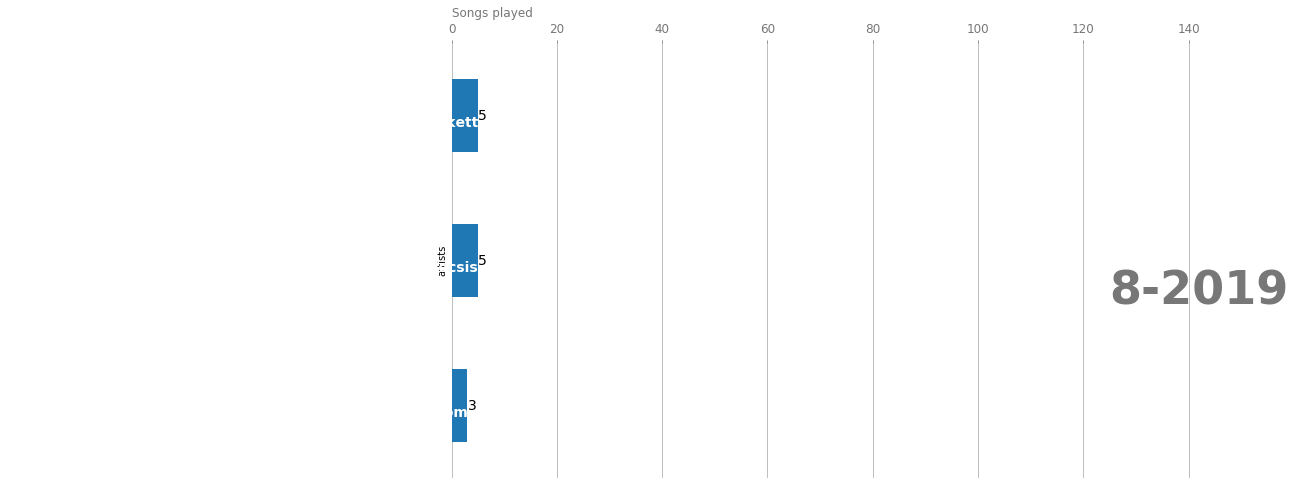

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))


animator = animation.FuncAnimation(fig, 
                                   draw_barchart, 
                                   frames=frames, 
                                   interval=50)
HTML(animator.to_html5_video()) 
animator.save('./figures/songs_played_by_artist_monthly_cumulative.mp4')

In [13]:
all_feat_files = {}
for file in os.listdir(data_dir):
    filename = os.fsdecode(file)
    if filename.endswith('.json'):
        if filename.startswith('audio'):
            with open(os.path.join(os.fsdecode(data_dir), filename), 'r') as f:
                data_json = json.load(f)
                all_feat_files.update(data_json)

In [14]:
df = pd.DataFrame.from_dict(all_feat_files, orient='index')[0].apply(pd.Series)

In [15]:
df.columns

Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')

In [16]:
audio_features = ['acousticness', 
                  'danceability', 
                  'energy', 
                  'instrumentalness', 
                  'liveness', 
                  'loudness', 
                  'speechiness',
                  'tempo',
                  'valence'
                 ]

In [17]:
df = df.merge(tracks_df.reset_index(), on='id')

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()

In [20]:
df[audio_features] = scaler.fit_transform(df[audio_features])

In [21]:
df[audio_features]

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,1.008970,-0.513055,-0.542189,1.001505,-0.380072,0.154078,-0.434191,0.282150,1.175390
1,1.204090,1.113369,-1.767514,1.550181,-0.632727,-3.428244,-0.462125,-0.405310,1.104794
2,1.198887,-1.431879,-1.537237,1.432608,-0.629920,-0.803799,-0.401020,-1.330921,-0.909048
3,1.526688,-0.428565,-1.450620,1.330711,-0.402530,-1.057861,-0.304996,0.243196,-0.656389
4,-1.040987,-0.513055,1.517624,-0.895338,0.636163,0.764010,0.990444,0.999543,-0.990791
...,...,...,...,...,...,...,...,...,...
2007,-1.041030,0.120617,1.584524,-0.895111,0.535101,1.250340,1.095196,-0.153348,-0.459463
2008,-1.040893,-0.439126,1.602129,-0.846228,-0.664730,1.049010,0.372404,0.135321,-0.708407
2009,-1.041050,0.083653,1.584524,-0.894822,0.428425,1.293471,0.311298,0.608253,-0.102768
2010,-1.041001,0.210387,1.566919,-0.895111,-0.054427,1.265580,0.103539,-0.252600,0.227918


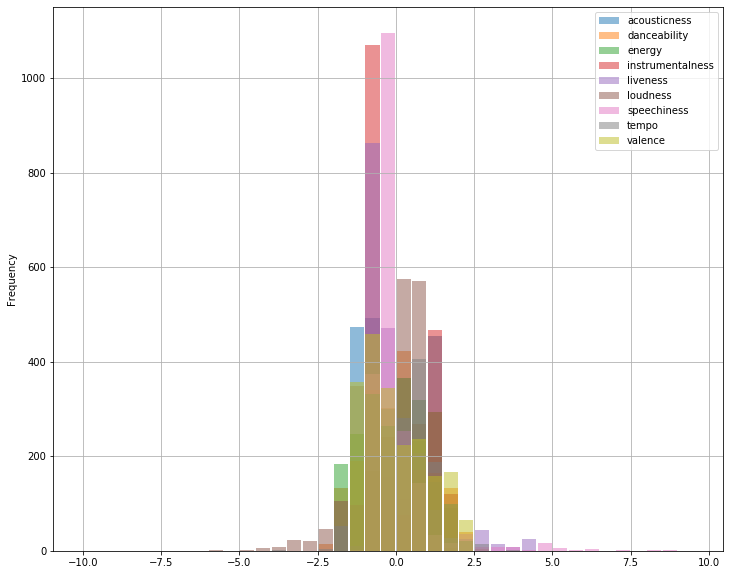

In [29]:
df[audio_features].plot.hist(bins=np.arange(-10, 10, 0.5),
                             figsize=(12, 10),
                             grid=True,
                             alpha=.5, 
                             rwidth=.9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e5e7860>,
      dtype=object)

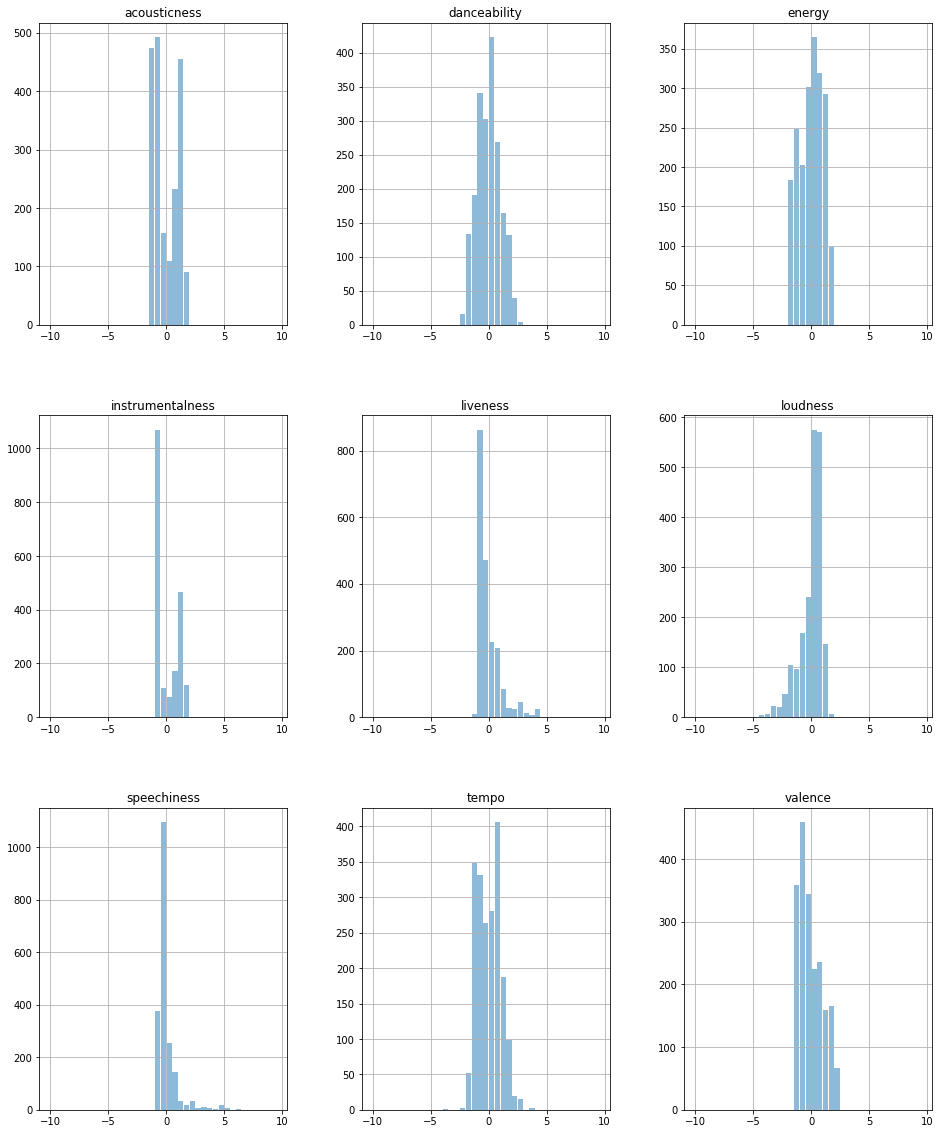

In [32]:
df[audio_features].hist(bins=np.arange(-10, 10, 0.5),
                             figsize=(16, 20),
                             grid=True,
                             alpha=.5, 
                             rwidth=.9)

In [33]:
plotlydf = px.data.tips()

In [ ]:
# create the bins
counts, bins = np.histogram(df[audio_features].total_bill, bins=range(0, 60, 5))
bins = 0.5 * (bins[:-1] + bins[1:])

fig = px.bar(x=bins, y=counts, labels={'x':'total_bill', 'y':'count'})
fig.show()

In [34]:
import plotly.graph_objects as go

In [39]:
fig = go.Figure()
for f in audio_features:
    fig.add_trace(go.Histogram( x=df[f],
                                histnorm='percent',
                                name=f,
                                xbins=dict(
                                    start=-10.0,
                                    end=10,
                                    size=0.1
                                ),
                                opacity=0.75
                              )
                 )
    

fig.update_layout(
    title_text='Sampled Results', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
)

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
plot(fig)

'temp-plot.html'

In [41]:
count_by_artist = df.groupby('artists').played_at.count()

In [42]:
artists = count_by_artist[count_by_artist>5].index.tolist()

In [43]:
artist_to_int = {k: i for i, k in enumerate(df.artists.unique())}

In [44]:
cols = df[df.artists.isin(artists)].artists.replace(to_replace=artist_to_int).values

In [60]:
mapper = umap.UMAP(n_neighbors=5)

In [61]:
audio_features_reduced = mapper.fit_transform(df[df.artists.isin(artists)].groupby('artists')[audio_features].median())

In [62]:
audio_features_reduced = pd.DataFrame(audio_features_reduced, columns=['x0', 'x1'])

audio_features_reduced['artists'] = df[df.artists.isin(artists)].reset_index()['artists']

In [63]:
fig = px.scatter(audio_features_reduced, x='x0', y="x1", color="artists", hover_data=['artists'])
plot(fig)
fig.write_html('./figures/umap_nn100_artists.html')

In [55]:
df[df.artists.isin(artists)].groupby('artists')[audio_features].median()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
artists,,,,,,,,,
Alexander Toradze-Mariinsky Orchestra-Sergei Prokofiev-Valery Gergiev,1.456445,-1.167849,-1.366114,1.435220,-0.610269,-1.432629,-0.497043,-1.367264,-1.190317
Andrew Mogrelia-Sergei Prokofiev-Ukraine National Symphony Orchestra,1.354983,-1.014712,-1.575265,1.311115,-0.183562,-1.436439,-0.406257,-0.711440,-0.899759
Angra,-0.986585,-0.779725,1.156717,-0.879749,-0.410952,0.815752,0.798397,0.649090,-0.660105
Anne-Sophie Mutter-John Williams-The Recording Arts Orchestra of Los Angeles,1.141652,-1.347389,-1.035136,0.277775,-0.671467,-0.583266,-0.346897,-0.976370,-1.161336
Antonín Dvořák-Saint Petersburg Philharmonic-Yuri Temirkanov,1.280837,-1.611419,-1.527378,1.329404,-0.211635,-1.414036,-0.404511,-1.247958,-0.890470
...,...,...,...,...,...,...,...,...,...
The Flower Kings,-0.635239,0.073092,0.563420,-0.894274,-0.172333,0.606421,-0.387053,0.273658,-0.277400
The Mauskovic Dance Band,0.033372,1.361558,0.116247,1.448284,-0.593425,0.009444,-0.046607,0.044544,1.572957
The Tangent,-0.886553,0.186625,0.681375,-0.893166,-0.520436,0.511472,-0.366102,0.393444,-0.028456


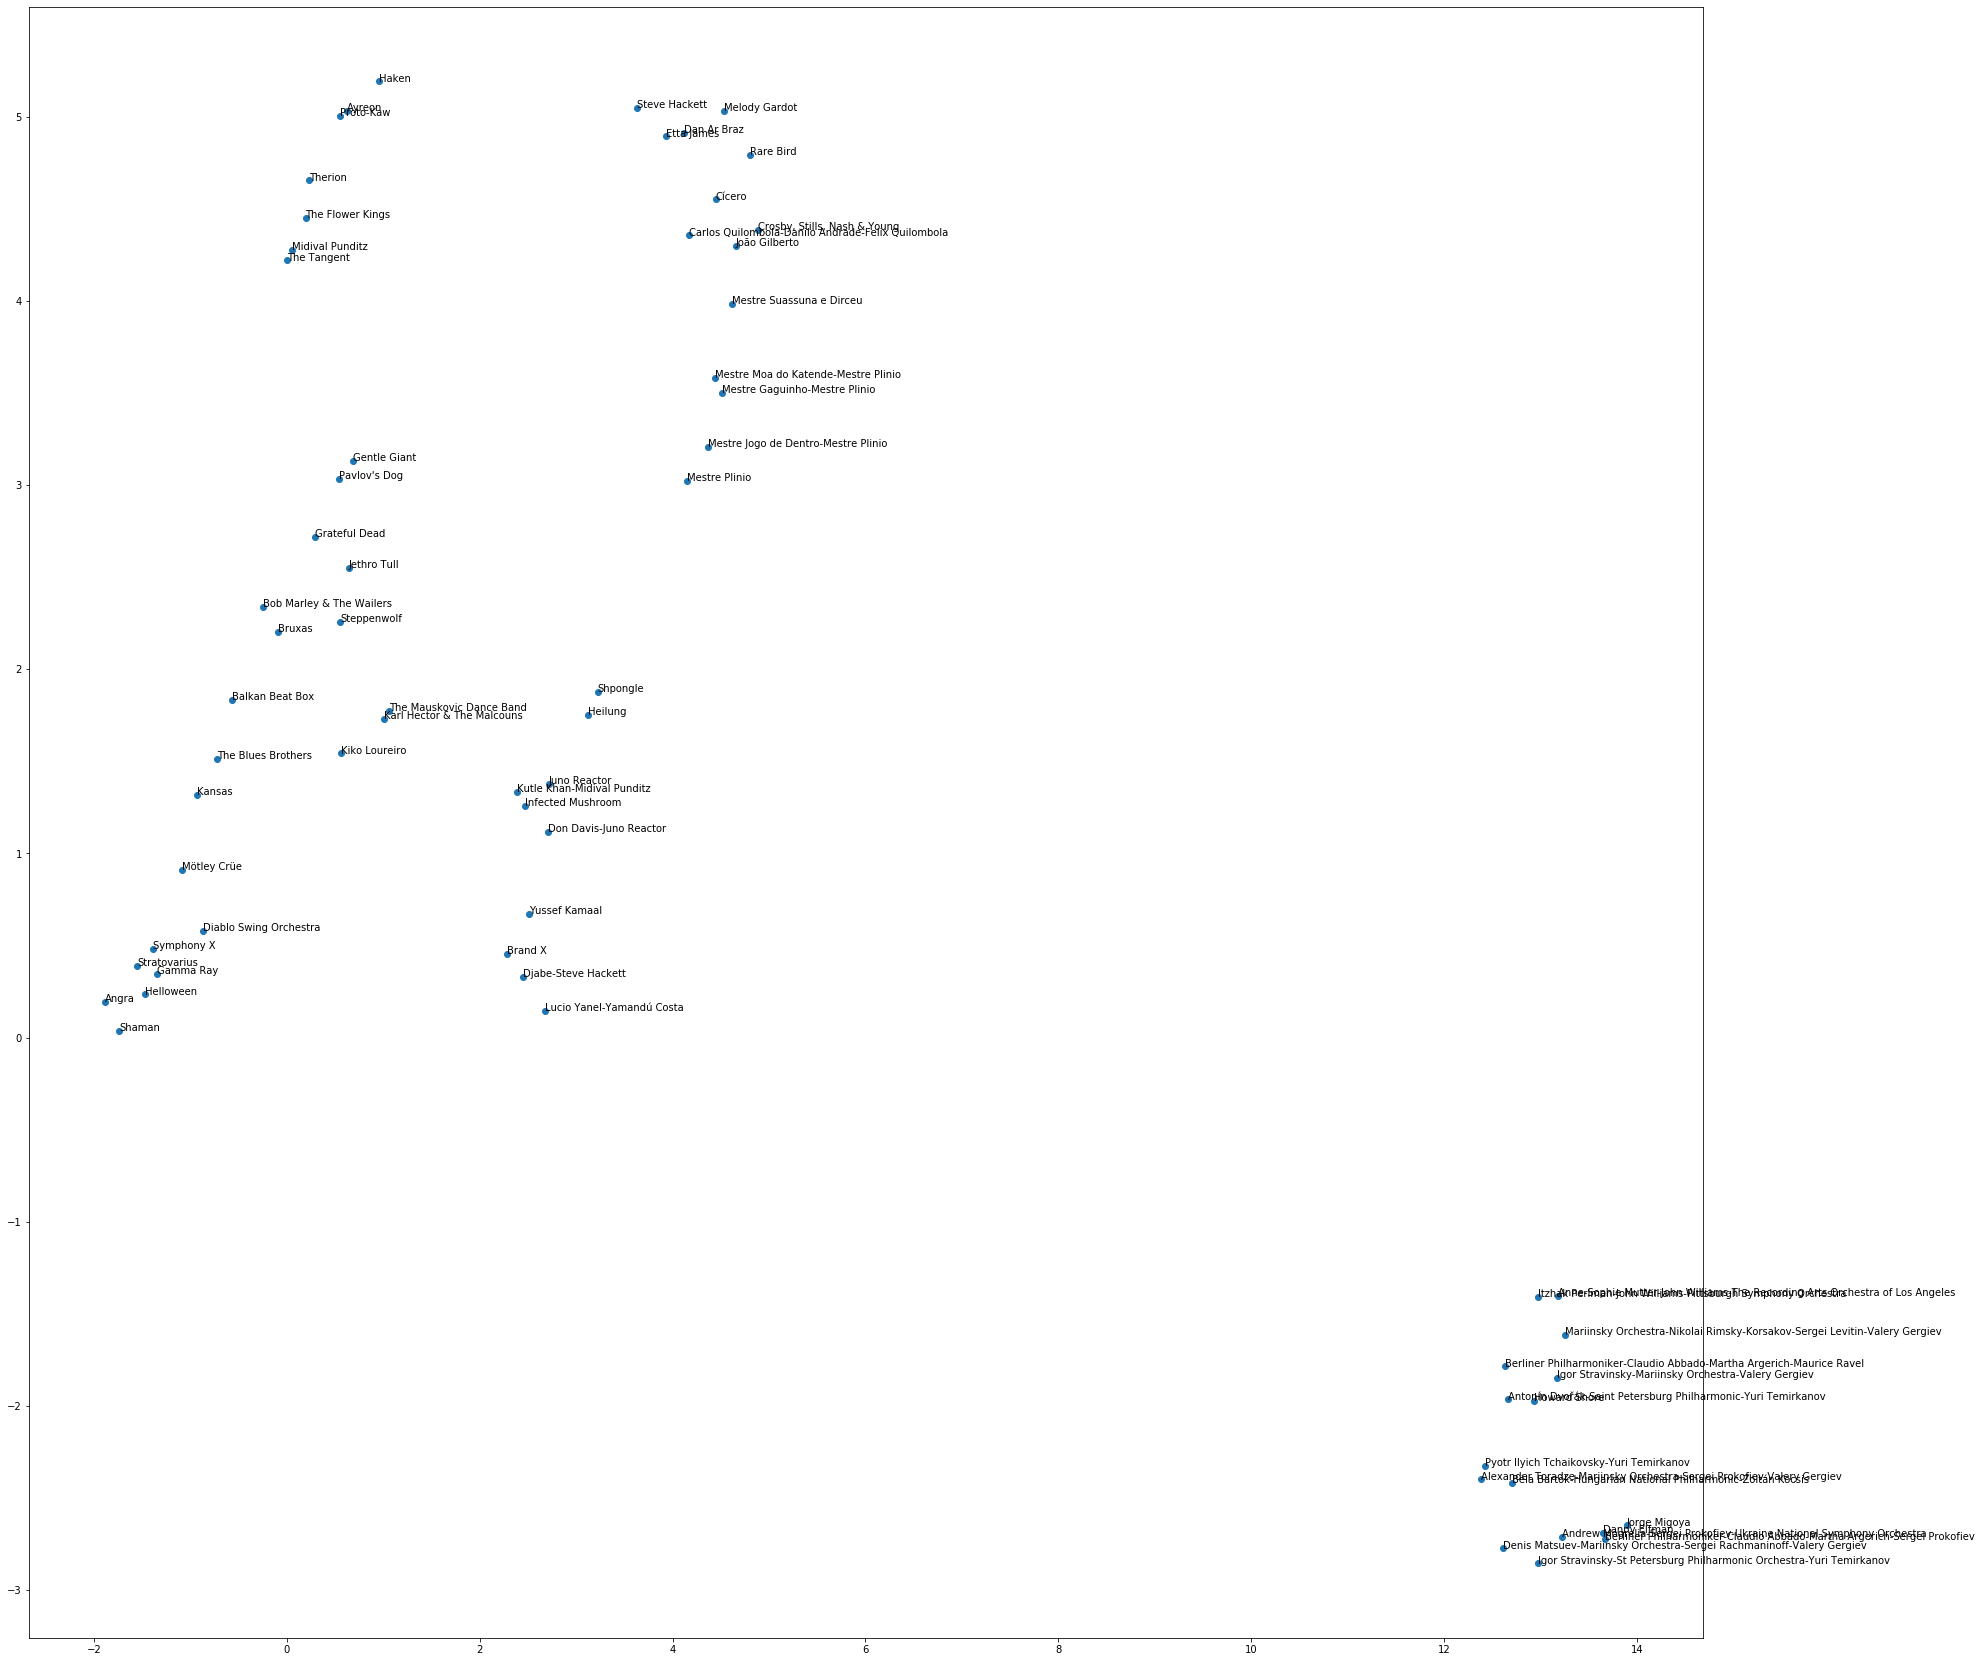

In [34]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.scatter(*audio_features_reduced.T)

for i, txt in enumerate(artists):
    ax.annotate(txt, (audio_features_reduced[i, 0], audio_features_reduced[i, 1]))

In [35]:
audio_features = ['acousticness', 
                  'danceability', 
                  'energy', 
                  'instrumentalness', 
                  'liveness', 
                  'speechiness',
                  'tempo',
                  'valence',
                  'mode',
                 ]

In [36]:
artists = count_by_artist[count_by_artist>5].index.tolist()

In [37]:
len(artists)

68

In [38]:
artist_to_int = {k: i for i, k in enumerate(artists)}

In [39]:
cols = df[df.artists.isin(artists)].artists.replace(to_replace=artist_to_int).values

In [40]:
mapper = umap.UMAP(n_neighbors=50)

In [41]:
audio_features_reduced = mapper.fit_transform(df[df.artists.isin(artists)][audio_features])

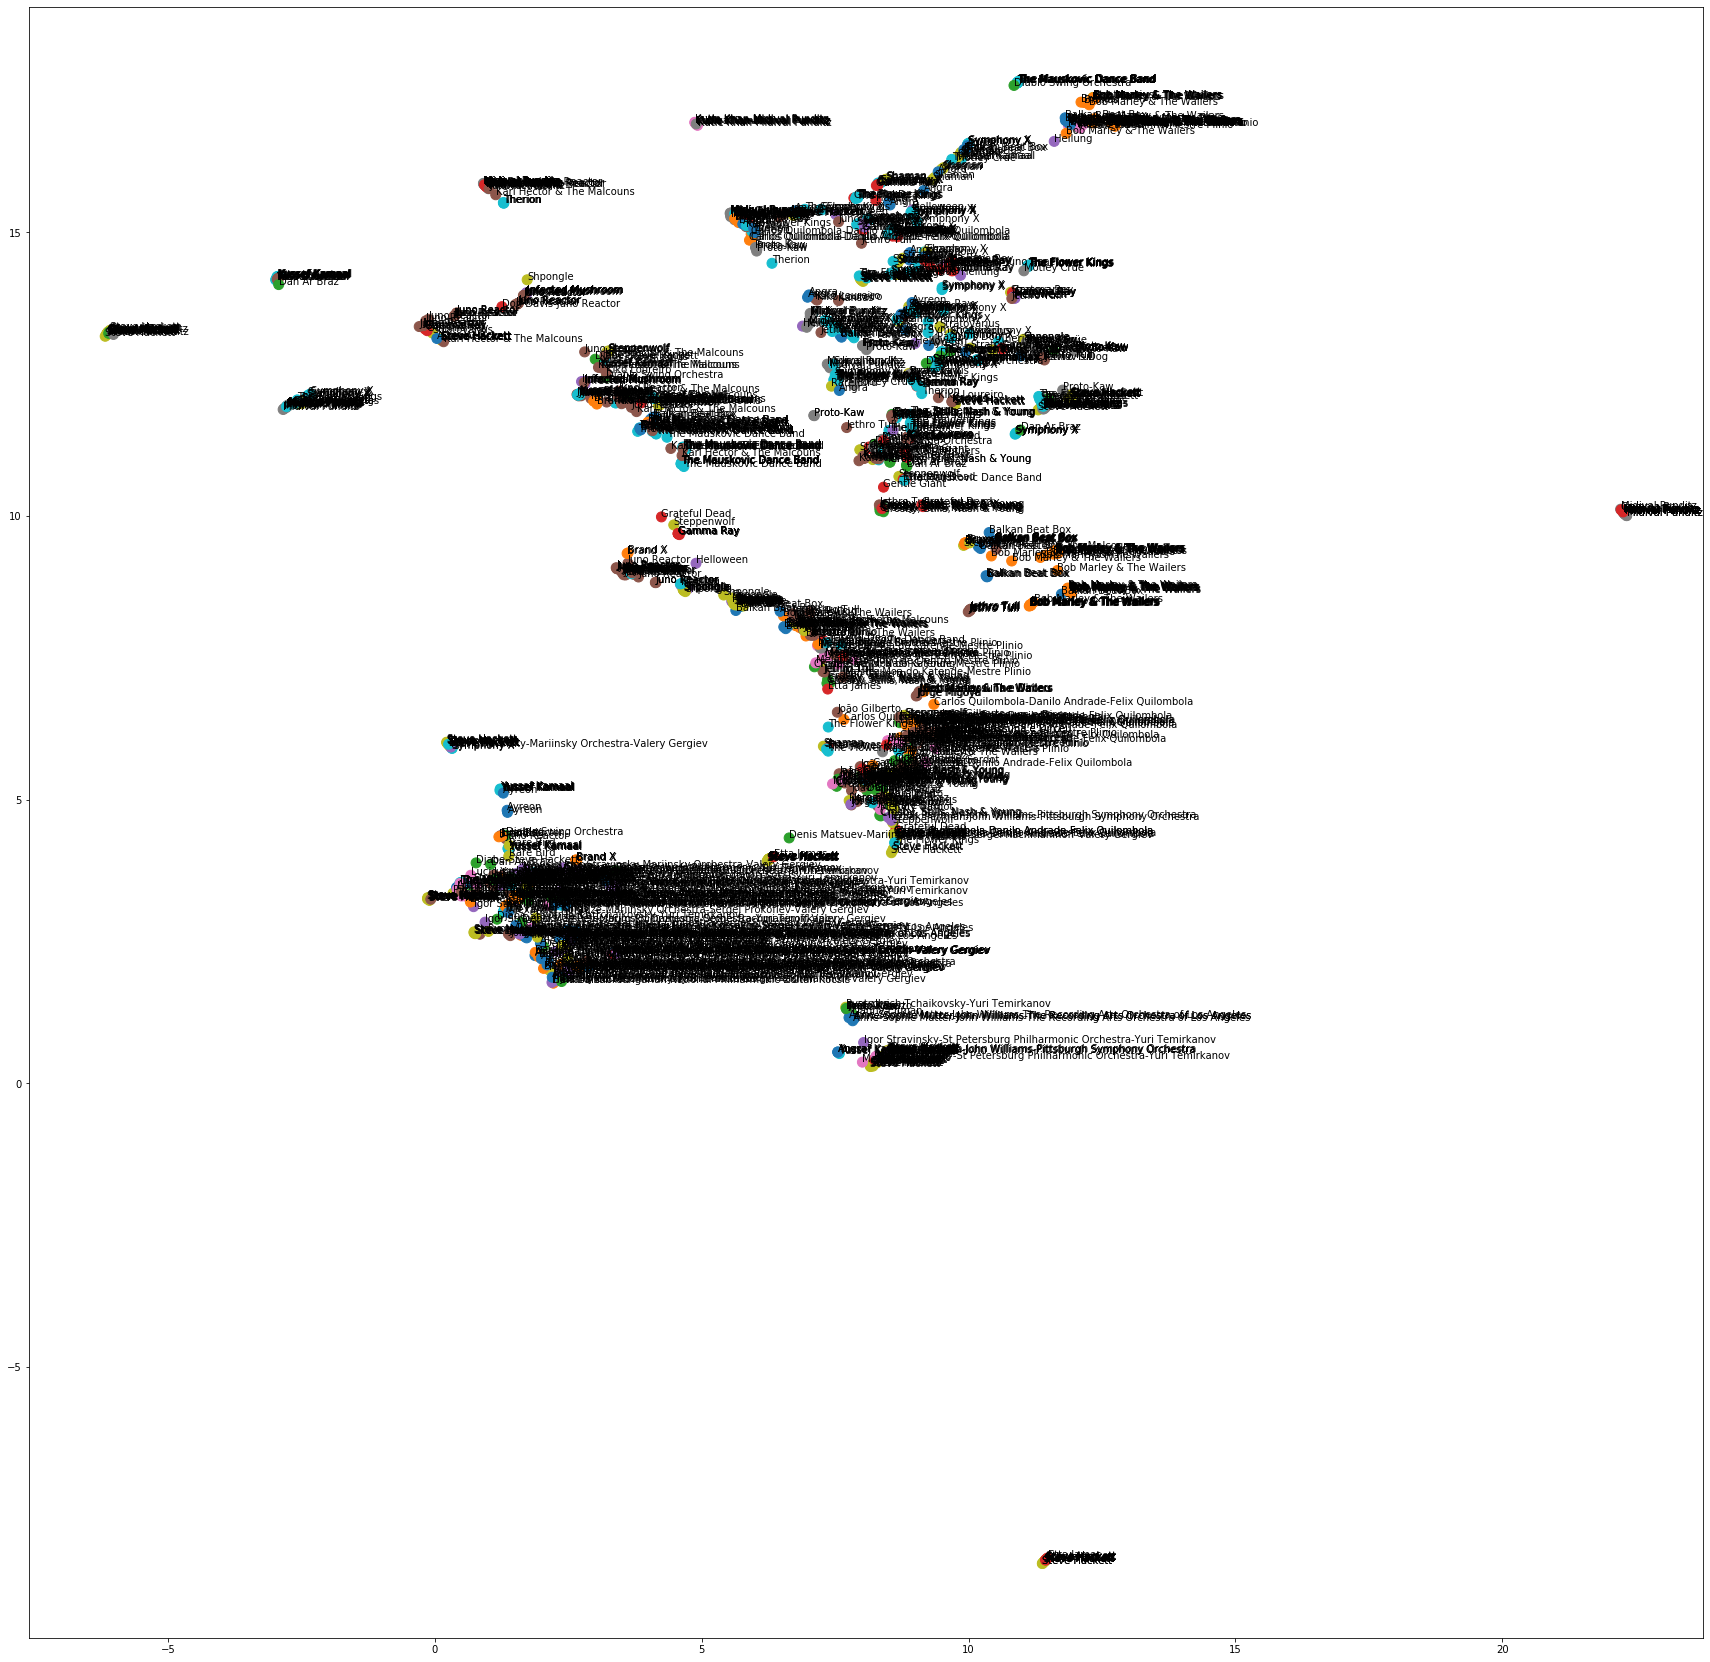

In [42]:
fig, ax = plt.subplots(figsize=(30, 30))
plt.scatter(*audio_features_reduced.T, c=cols, s=100, cmap='tab10')

for i, txt in enumerate(df[df.artists.isin(artists)].artists):
    ax.annotate(txt, (audio_features_reduced[i, 0], audio_features_reduced[i, 1]))

In [43]:
df_reduced = pd.DataFrame(audio_features_reduced, columns=['x0', 'x1'])
df_reduced['artists'] = df[df.artists.isin(artists)].reset_index()['artists']
df_reduced['name'] = df[df.artists.isin(artists)].reset_index()['name']

In [44]:
df_reduced = df_reduced.groupby(['artists', 'name']).mean().reset_index()

In [45]:
fig = px.scatter(df_reduced, x='x0', y="x1", color="artists", hover_data=['name', 'artists'])
plot(fig)
fig.write_html('./figures/umap_nn100.html')